# How far can we push the noise?

In this notebook, we will explore the performance of our  models when we add noise to the input data. You can also use this to generate an approximation to the hybrid data set, assuming you have already extracted Walch et al.'s data. The hybrid data set we published on with the NHRC is a combination of the Walch et al. data and recordings from a gyroscope on a Naval ship at sea.

This notebook was created to explore what happens to performance in the very-high-noise regime. We push normally distributed noise (aka white noise) into the hybrid input data and observe the performance of the models. We also explore the effect of the noise on the models' predictions.

In [1]:
from typing import List
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType

In [2]:

import os
from pathlib import Path

CWD = Path(os.getcwd())
save_path = CWD.joinpath("pre_processed_data")
hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)
# hardcoded data locations are easiest, if most brittle
data_location = Path('../../data')


In [4]:
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects. (Expected: 31)")

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects. (Expected: 31)")

Found 31 subjects. (Expected: 31)
Found 31 subjects. (Expected: 31)


In [5]:
subjects_to_exclude_walch = [
    "7749105",
    "5383425", "8258170"
]

# SAME subjects, hybrid is fuzzed data
subjects_to_exclude_hybrid = subjects_to_exclude_walch

In [6]:
sampling_hz = 32 # Hz
input_features = ['accelerometer']
model_input = ModelInputSpectrogram(input_features, sampling_hz)
output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
data_processor_walch = DataProcessor(walch, model_input, output_type=output_type,
                                     psg_type=PSGType.HAS_N4)

In [ ]:
import sys
from typing import Dict
import numpy as np
from scipy.signal import spectrogram

from examples.NHRC.nhrc_utils.model_definitions import LR_ACTIVITY_INPUTS
import pisces.data_sets as pds
from pisces.utils import resample_accel_data, build_ADS

FIXED_LABEL_LENGTH = 1024
# FIXED_SPECGRAM_SHAPE = (15360, 32, 3)
FIXED_SPECGRAM_SHAPE = (15360, 32)

ACC_DIFF_GAP = 10 # seconds
ACC_RAW_HZ = 50
ACC_RAW_DT = 1/ACC_RAW_HZ
ACC_INPUT_HZ = 32
ACTIVITY_DT = 15
ACTIVITY_HZ = 1/ACTIVITY_DT
PSG_DT = 30
PSG_HZ = 1/PSG_DT
SECONDS_PER_KERNEL = 5 * 60
ACTIVITY_KERNEL_WIDTH = SECONDS_PER_KERNEL * ACTIVITY_HZ
ACTIVITY_KERNEL_WIDTH += 1 - (ACTIVITY_KERNEL_WIDTH % 2)  # Ensure it is odd

def process_data(dataset: pds.DataSetObject, id, ACTIVITY_KERNEL_WIDTH, add_accel_noise: float = 0.0) -> Dict[str, np.ndarray]:
    # Load data
    accel_data = dataset.get_feature_data('accelerometer', id).to_numpy()
    activity_data = dataset.get_feature_data('activity', id).to_numpy()
    psg_data = dataset.get_feature_data('psg', id).to_numpy()

    # Sort based on time (axis 0)
    accel_data = accel_data[accel_data[:, 0].argsort()]
    activity_data = activity_data[activity_data[:, 0].argsort()]
    psg_data = psg_data[psg_data[:, 0].argsort()]
    if add_accel_noise > 0.0:
        accel_data[:, 1:] = np.random.normal(loc=accel_data[:, 1:], scale=add_accel_noise)
        activity_time, activity = build_ADS(accel_data)
        activity_data = np.column_stack((activity_time, activity))
        activity_data = activity_data[activity_data[:, 0].argsort()]

    # Convert activity and PSG time to int
    activity_data[:, 0] = np.round(activity_data[:, 0])
    psg_data[:, 0] = np.round(psg_data[:, 0])
    
    # Trim data to common time range
    start_time = max(accel_data[0, 0], activity_data[0, 0], psg_data[0, 0])
    end_time = min(accel_data[-1, 0], activity_data[-1, 0], psg_data[-1, 0])
    
    accel_data = accel_data[(accel_data[:, 0] >= start_time) & (accel_data[:, 0] <= end_time)]
    activity_data = activity_data[(activity_data[:, 0] >= start_time) & (activity_data[:, 0] <= end_time)]
    psg_data = psg_data[(psg_data[:, 0] >= start_time) & (psg_data[:, 0] <= end_time)]

    # print("PSG Shape", psg_data.shape)
    
    # Find gaps in accelerometer data
    time_diff = np.diff(accel_data[:, 0])
    avg_time_hz = int(1/np.median(time_diff))
    avg_time_diff = 1/avg_time_hz
    gap_indices = np.where(time_diff > ACC_DIFF_GAP)[0]
    
    # Mask PSG labels during accelerometer gaps
    n_psg_mask = np.sum(psg_data[:, 1] < 0)
    len_psg = psg_data.shape[0]
    # print("# of masked epochs: ", n_psg_mask, "out of", len_psg, f"({100 * n_psg_mask / len_psg:.2f}%)")
    pre_mask_sleeps = np.sum(psg_data[:, 1] > 0)
    pre_mask_wakes = np.sum(psg_data[:, 1] == 0)
    wakes_masked = 0
    # print("Pre-mask:\n\tSleeps", pre_mask_sleeps, "\n\tWakes", pre_mask_wakes)
    for gap_index in gap_indices:
        gap_start = accel_data[gap_index, 0] + ACC_DIFF_GAP 
        gap_end = accel_data[gap_index + 1, 0]
        mask_indices = np.where((psg_data[:, 0] + PSG_DT >= gap_start) & (psg_data[:, 0] <= gap_end))[0]
        wake_counts = np.sum((psg_data[mask_indices, 1].astype(int)) == 0)
        wakes_masked += wake_counts
        sleep_counts = np.sum((psg_data[mask_indices, 1].astype(int)) > 0)
        psg_data[mask_indices, 1:] = -1  # Assuming labels are in columns from index 1 onwards
    
    post_mask_sleeps = np.sum(psg_data[:, 1] > 0)
    post_mask_wakes = np.sum(psg_data[:, 1] == 0)
    # print("Post-mask:\n\tSleeps", post_mask_sleeps, "\n\tWakes", post_mask_wakes, "\n\tWakes masked", wakes_masked)
    # masking_df = masking_df.append({"id": id, "pre_mask_sleeps": pre_mask_sleeps, "pre_mask_wakes": pre_mask_wakes, "post_mask_sleeps": post_mask_sleeps, "post_mask_wakes": post_mask_wakes, "wakes_masked": wakes_masked}, ignore_index=True)
    
    # Convert accelerometer data to spectrograms
    # accel_data_resampled = resample_accel_data(accel_data, original_fs=int(avg_time_hz), target_fs=ACC_INPUT_HZ)
    accel_data_resampled = resample_accel_data(accel_data, original_fs=32, target_fs=ACC_INPUT_HZ)
    spectrograms = data_processor_walch.accelerometer_to_spectrogram(accel_data_resampled)
    padded_spectrograms = np.zeros(FIXED_SPECGRAM_SHAPE)
    padded_spectrograms[:spectrograms.shape[0], ...] = spectrograms[:FIXED_SPECGRAM_SHAPE[0], ...]
    
    # Pad PSG data to 1024 samples
    psg_data = pad_or_truncate(psg_data, int(FIXED_LABEL_LENGTH))
    
    # Pad activity data to 2 * 1024 samples
    activity_data = pad_or_truncate(activity_data, int(LR_ACTIVITY_INPUTS))
    
    return {"spectrogram": padded_spectrograms, "activity": activity_data, "psg": psg_data}

import numpy as np
def pad_or_truncate(data, desired_length, pad_value: float = -1.0):
    current_length = data.shape[0]
    if current_length < desired_length:
        padding = desired_length - current_length
        pad_width = ((0, padding), (0, 0))
        data = np.pad(data, pad_width, mode='constant', constant_values=pad_value)
    else:
        data = data[:desired_length, :]
    return data


LR_KERNEL_SIZE: 61


In [9]:

def fuzz_data(dataset: pds.DataSetObject, id, add_accel_noise: float = 0.0) -> Dict[str, np.ndarray]:
    # masking_df = pd.DataFrame(columns=["id", "pre_mask_sleeps", "pre_mask_wakes", "post_mask_sleeps", "post_mask_wakes", "wakes_masked"])
    # Load data
    accel_data = dataset.get_feature_data('accelerometer', id).to_numpy()
    activity_data = dataset.get_feature_data('activity', id).to_numpy()

    # Sort based on time (axis 0)
    accel_data = accel_data[accel_data[:, 0].argsort()]
    activity_data = activity_data[activity_data[:, 0].argsort()]
    if add_accel_noise > 0.0:
        accel_data[:, 1:] = np.random.normal(loc=accel_data[:, 1:], scale=add_accel_noise)
        activity_time, activity = build_ADS(accel_data)
        activity_data = np.column_stack((activity_time, activity))
        activity_data = activity_data[activity_data[:, 0].argsort()]
    
    return {"accelerometer": accel_data, "activity": activity_data}

In [10]:

idx = np.random.randint(0, len(walch.ids))
id_name = walch.ids[idx]
print(f"Processing subject {id_name}")

Processing subject 9106476


In [11]:
def z_norm(data):
    data = data - np.mean(data)
    data = data / np.std(data)
    return data

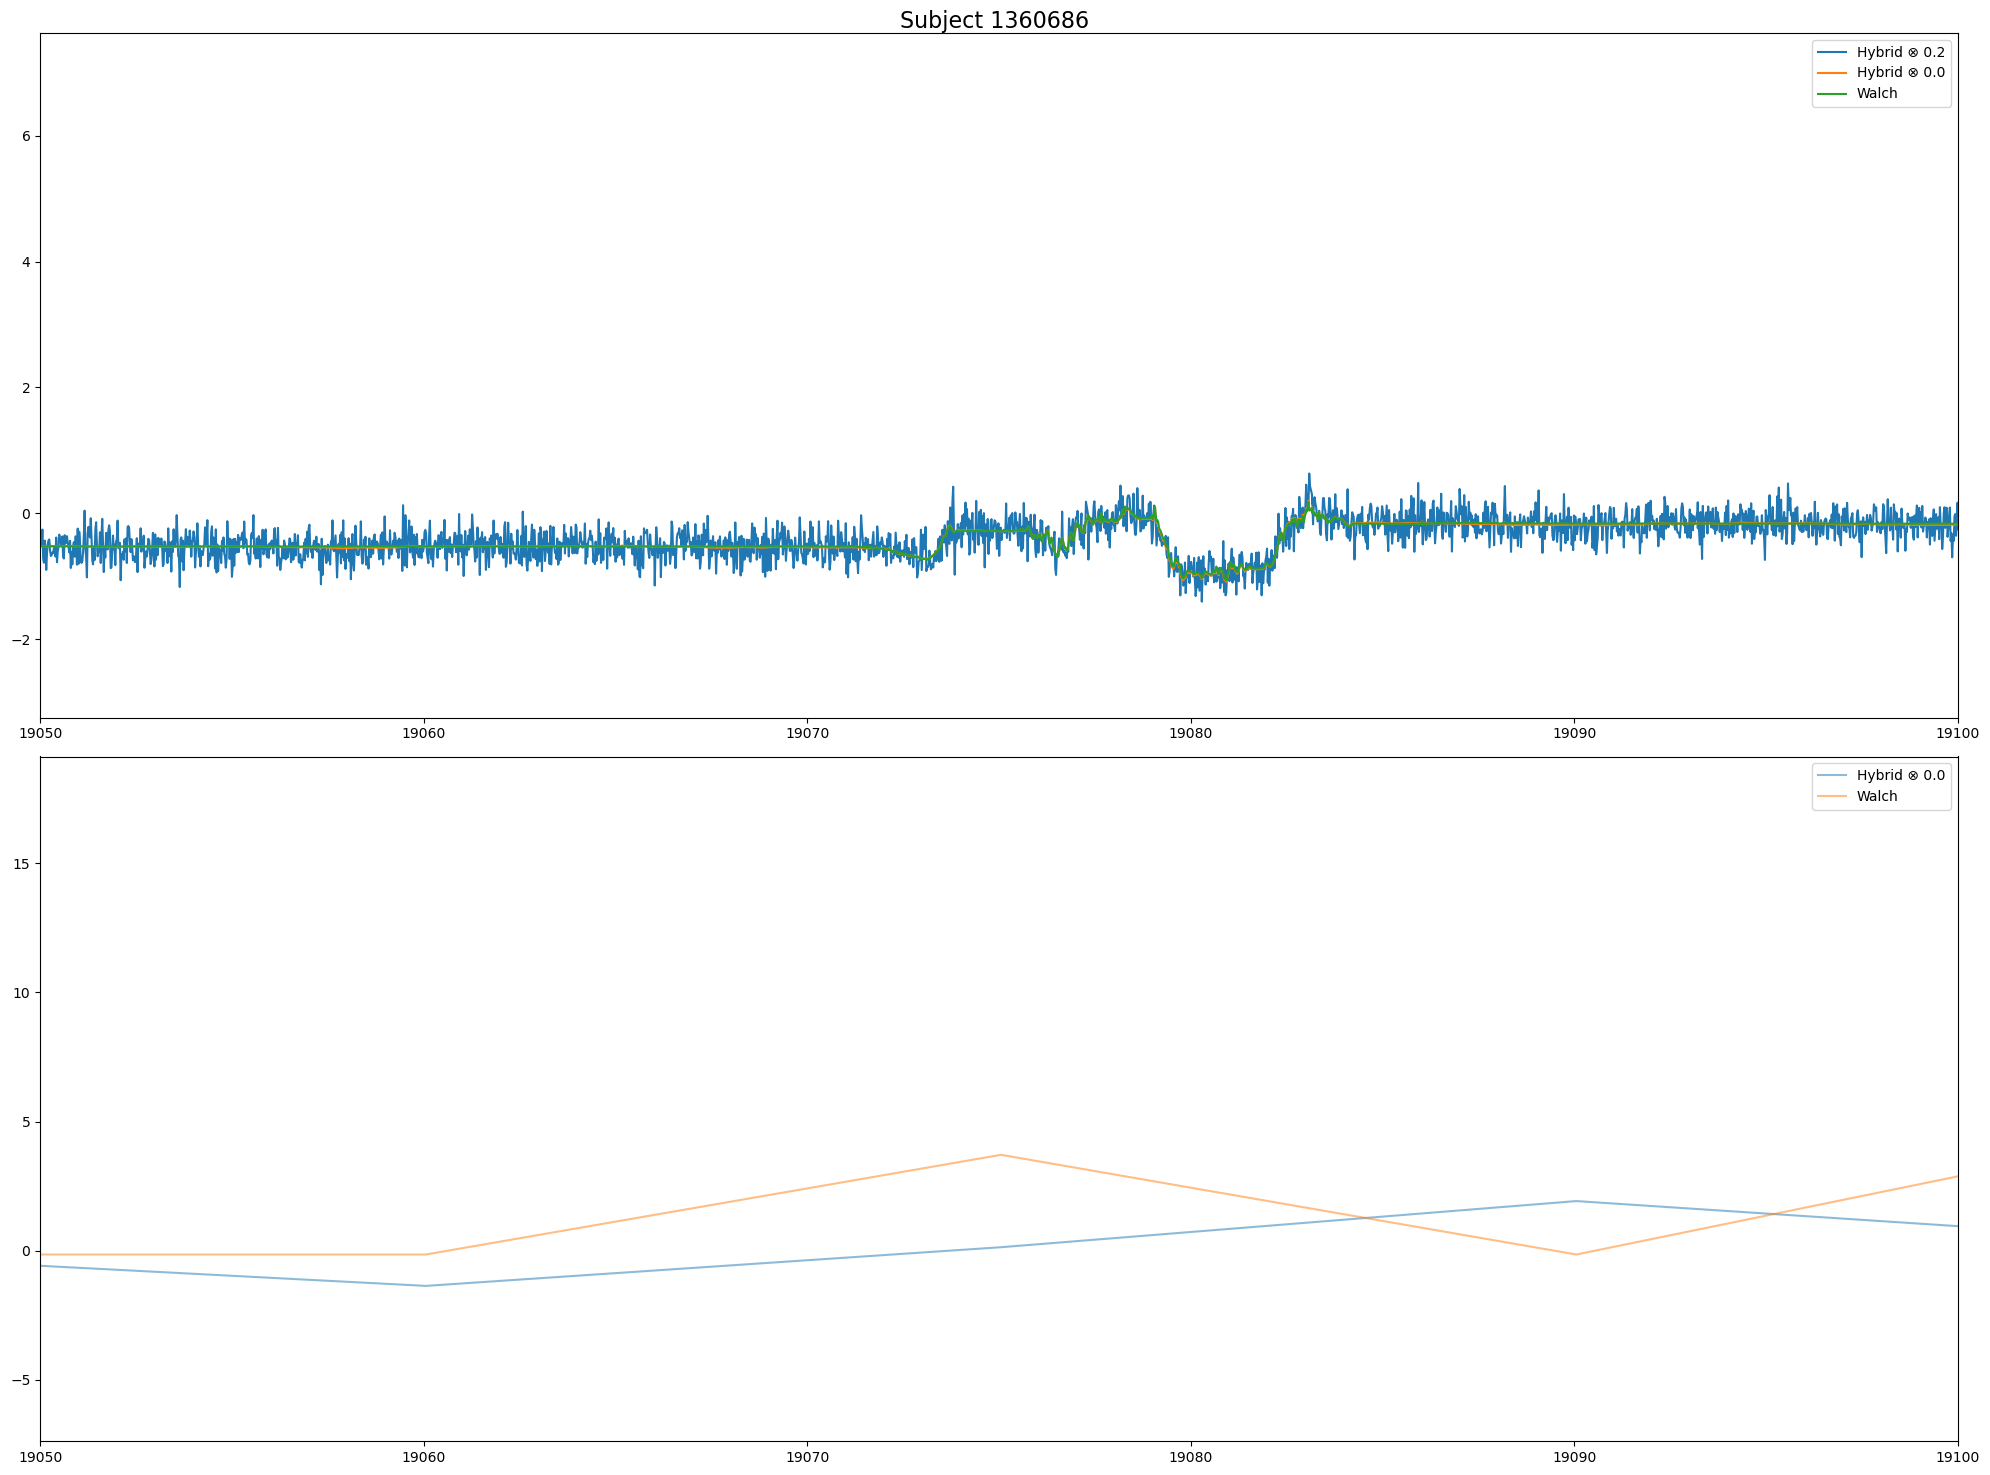

In [12]:
from matplotlib import pyplot as plt

id_name = '1360686'

noise_levels = [0.2, 0.0]
n_noise = len(noise_levels)

wdata = fuzz_data(walch, id_name, add_accel_noise=0.0)
hdata = np.array([
    fuzz_data(hybrid, id_name, add_accel_noise=n)
    for n in noise_levels
])

wpsg = walch.get_feature_data('psg', id_name).to_numpy()

fig, ax = plt.subplots(2, 1, figsize=(20, 15))

acc_time = wdata['accelerometer'][:, 0]
hdata[0]['accelerometer'] = hdata[0]['accelerometer'][:len(acc_time)]
zoom_start = 19050
zoom_end = 19100
acc_time_zoom = (acc_time > zoom_start) & (acc_time < zoom_end) 
activity_time = wdata['activity'][:, 0]
# activity_time_zoom = activity_time > zoom_start & activity_time < zoom_end 

# iterate over noises in reverse, since noise gets bigger and covers prior noises
for i, n in enumerate(noise_levels):
    ax[0].plot(hdata[i]['accelerometer'][:, 0], hdata[i]['accelerometer'][:, 1], label=f"Hybrid ⊗ {n}")
ax[1].plot(hdata[0]['activity'][:, 0], z_norm(hdata[0]['activity'][:, 1]), label=f"Hybrid ⊗ {n}", alpha=0.5)
# ax[0].plot(hdata['accelerometer'][:, 0], hdata['accelerometer'][:, 1], label="Hybrid")
ax[0].plot(wdata['accelerometer'][acc_time_zoom, 0], wdata['accelerometer'][acc_time_zoom, 1], label="Walch")

ax[1].plot(wdata['activity'][:, 0], z_norm(wdata['activity'][:, 1]), label="Walch", alpha=0.5)

for axis in ax:
    axis.set_xlim([zoom_start, zoom_end])
    axis.legend()

fig.suptitle(f"Subject {id_name}", fontsize=16)
fig.tight_layout()

# wpsg_mask = wpsg[:, 1] < 0
# wpsg_mask_times = wpsg[wpsg_mask, 0]
# # shade the regions where the PSG is masked
# for i in range(0, len(wpsg_mask_times), 2):
#     ax[1].axvspan(wpsg_mask_times[i], wpsg_mask_times[i+1], color='red', alpha=0.5)

In [8]:
from tqdm import tqdm
def process_data_set(data_set: pds.DataSetObject, ids_to_exclude: List[str], ACTIVITY_KERNEL_WIDTH, add_accel_noise: float = 0.0) -> Dict[str, Dict[str, np.ndarray]]:
    data = {}
    d = tqdm(data_set.ids)
    for id in d:
        if id in ids_to_exclude:
            continue
        # d.set_description(f"Processing {id}")
        data[id] = process_data(data_set, id, ACTIVITY_KERNEL_WIDTH, add_accel_noise=add_accel_noise)
    return data

In [ ]:
from examples.NHRC.nhrc_utils.analysis import prepare_data


dataset = "stationary"
walch_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data_32.npy',
                                   allow_pickle=True).item()
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [10]:
import pandas as pd
import tensorflow as tf
from analyses.NHRC.nhrc_utils.model_definitions import MODEL_TYPES, cnn_pred_proba, lr_cnn_pred_proba, naive_pred_proba
from analyses.NHRC.nhrc_utils.analysis import SCENARIOS, EVALUATION_COLUMNS, DF_COLUMNS, auroc_balaccuracy_wasa, WASA_COLUMN

WASA_SLEEP_ACCURACY = [0.93, 0.95, 0.97]

keys = list(walch_preprocessed_data.keys())

cnn_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/finetuning_{i}.keras")
    for i in keys
]

lr_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/lr_{i}.keras")
    for i in keys
]

DF_plus_noise = DF_COLUMNS + ["noise"]

evaluations_df = pd.DataFrame([], columns=DF_plus_noise)
scenarios = SCENARIOS
model_types = MODEL_TYPES 

In [11]:
model_types

['lr', 'finetuning', 'naive']

In [12]:


def eval_loop(NOISE: float, t: tqdm | None = None):
    global evaluations_df
    if t is not None:
        t.set_description(f"+++++ NOISE IS {NOISE:0.2f} +++++")
    hybrid_preprocessed_data = process_data_set(hybrid, subjects_to_exclude_hybrid, ACTIVITY_KERNEL_WIDTH, add_accel_noise=NOISE)
    hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)
    evals = {s: 
        {m: [] for m in model_types} 
        for s in scenarios
    }

    for test_idx in range(len(hybrid_preprocessed_data)):
        # extract inputs
        stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
        stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
        stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
        stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
        stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

        hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
        hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

        # z-normalize input data
        stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
        hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


        # process inputs into predictions
        stationary_naive = naive_pred_proba(stationary_wldm_predictions)
        stationary_lr = lr_cnn_pred_proba(
                lr_predictors[test_idx], 
                stationary_lr_input)
        stationary_cnn = cnn_pred_proba(
                cnn_predictors[test_idx], 
                stationary_wldm_predictions)
        hybrid_naive = naive_pred_proba(hybrid_wldm_predictions)
        hybrid_cnn = cnn_pred_proba(
                cnn_predictors[test_idx],
                hybrid_wldm_predictions)
        hybrid_lr = lr_cnn_pred_proba(
                lr_predictors[test_idx],
                hybrid_lr_input)
        
        eval_dict = {
            "stationary_naive": stationary_naive,
            "stationary_finetuning": stationary_cnn,
            "stationary_lr": stationary_lr,
            "hybrid_naive": hybrid_naive,
            "hybrid_finetuning": hybrid_cnn,
            "hybrid_lr": hybrid_lr
        }

        for model in model_types:
            for scenario in scenarios:
                evals[scenario][model] = auroc_balaccuracy_wasa(
                    walch_keys[test_idx], 
                    eval_dict[f'{scenario}_{model}'],
                    stationary_weights,
                    stationary_labels_masked,
                    sleep_accuracy=WASA_SLEEP_ACCURACY)

        # now append each evaluation to the dataframe, labeled correctly
        evaluations_df = pd.concat([evaluations_df,
                                    pd.DataFrame([
                [walch_keys[test_idx],
                scenario,
                model,
                *evals[scenario][model][i],
                int(100 * WASA_SLEEP_ACCURACY[i]),
                NOISE]
                for scenario in scenarios for model in model_types
                for i in range(len(WASA_SLEEP_ACCURACY))
            ], columns=DF_plus_noise
        )], ignore_index=True)


In [13]:
noises_0 = np.linspace(0.0, 0.1, 11)
noises_1 = np.linspace(0.1, 0.5, 5)
noises = np.concatenate([noises_0, noises_1])

t = tqdm(noises)
for noise in t:
    eval_loop(noise, t=t)


100%|██████████| 31/31 [01:43<00:00,  3.34s/it]6 [00:00<?, ?it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_13090/2617648188.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df,


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 31/31 [01:52<00:00,  3.64s/it]6 [01:50<27:44, 110.94s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

100%|██████████| 31/31 [02:00<00:00,  3.89s/it]6 [03:52<27:23, 117.41s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/

100%|██████████| 31/31 [01:53<00:00,  3.65s/it]6 [05:58<26:16, 121.30s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

100%|██████████| 31/31 [01:53<00:00,  3.65s/it]6 [07:57<24:03, 120.26s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/

100%|██████████| 31/31 [01:57<00:00,  3.78s/it]6 [09:56<21:56, 119.64s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/

100%|██████████| 31/31 [01:59<00:00,  3.85s/it]6 [11:59<20:08, 120.85s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


100%|██████████| 31/31 [01:54<00:00,  3.68s/it]6 [14:04<18:21, 122.40s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/

100%|██████████| 31/31 [02:00<00:00,  3.88s/it]6 [16:04<16:12, 121.53s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

100%|██████████| 31/31 [01:57<00:00,  3.79s/it]6 [18:10<14:20, 122.87s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/

100%|██████████| 31/31 [01:54<00:00,  3.68s/it]16 [20:13<12:18, 123.00s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/

100%|██████████| 31/31 [02:02<00:00,  3.95s/it]16 [22:13<10:09, 121.97s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

100%|██████████| 31/31 [02:01<00:00,  3.92s/it]16 [24:23<08:18, 124.54s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1

100%|██████████| 31/31 [01:55<00:00,  3.73s/it]16 [26:31<06:16, 125.46s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

100%|██████████| 31/31 [01:56<00:00,  3.76s/it]16 [28:32<04:08, 124.34s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

100%|██████████| 31/31 [16:49<00:00, 32.55s/it]16 [30:35<02:03, 123.81s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

+++++ NOISE IS 0.50 +++++: 100%|██████████| 16/16 [47:30<00:00, 178.15s/it]


In [14]:
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np

def get_GMM(df: pd.DataFrame, column: str = WASA_COLUMN, n_components: int = 2):
    # Assuming `wasa_scores` is your array of WASA scores
    wasa_scores = df[column].values

    # Reshape data for sklearn (n_samples, n_features)
    X = wasa_scores.reshape(-1, 1)

    # Fit GMM with 2 components (you can try different numbers)
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(X)

    return gmm


def add_GMM(df: pd.DataFrame, ax: plt.Axes):
    gmm = get_GMM(df)

    wasa_scores = df[WASA_COLUMN].values.reshape(-1, 1)

    # Predict the component membership
    labels = gmm.predict(wasa_scores)

    # Get the weights (proportions) of each component
    weights = gmm.weights_

    print("Component Weights:", weights)

    # Extract component weights and means
    weights = gmm.weights_
    means = gmm.means_.flatten()

    # Identify components
    normal_mode_index = np.argmax(means)   # Component with higher mean
    failure_mode_index = np.argmin(means)  # Component with lower mean

    # Get weights for each mode
    normal_mode_weight = weights[normal_mode_index]
    failure_mode_weight = weights[failure_mode_index]

    print(f"Normal Mode Weight (Proportion): {normal_mode_weight:.2f}")
    print(f"Failure Mode Weight (Proportion): {failure_mode_weight:.2f}")
    # Generate a range of values for plotting the GMM
    x = np.linspace(wasa_scores.min(), wasa_scores.max(), 1000).reshape(-1, 1)

    # Compute the weighted densities
    logprob = gmm.score_samples(x)
    responsibilities = gmm.predict_proba(x)
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]

    # Plot the histogram and GMM components
    # plt.hist(wasa_scores, bins=30, density=True, alpha=0.6, color='gray')

    # Plot individual Gaussian components
    ax.plot(x, pdf_individual[:, normal_mode_index], label='Normal Mode', color='blue')
    ax.plot(x, pdf_individual[:, failure_mode_index], label='Failure Mode', color='red')

    # Plot the overall GMM density
    ax.plot(x, pdf, label='Overall GMM', color='black', linestyle='--')

    # plt.title('GMM Fit to WASA Scores')
    # plt.xlabel('WASA Score')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.show()


In [15]:
evaluations_df.head()

,test_id,scenario,model,AUROC,TST_Error,WASA,threshold,sleep_accuracy,noise
0,1066528,stationary,lr,0.748461,-24.5,0.342857,0.339451,93,0.0
1,1066528,stationary,lr,0.748461,-35.5,0.271429,0.287760,95,0.0
2,1066528,stationary,lr,0.748461,-43.0,0.250000,0.238615,97,0.0
3,1066528,stationary,finetuning,0.760703,-18.0,0.428571,0.165934,93,0.0
4,1066528,stationary,finetuning,0.760703,-31.0,0.328571,0.075249,95,0.0


In [16]:
gmm = get_GMM(evaluations_df)

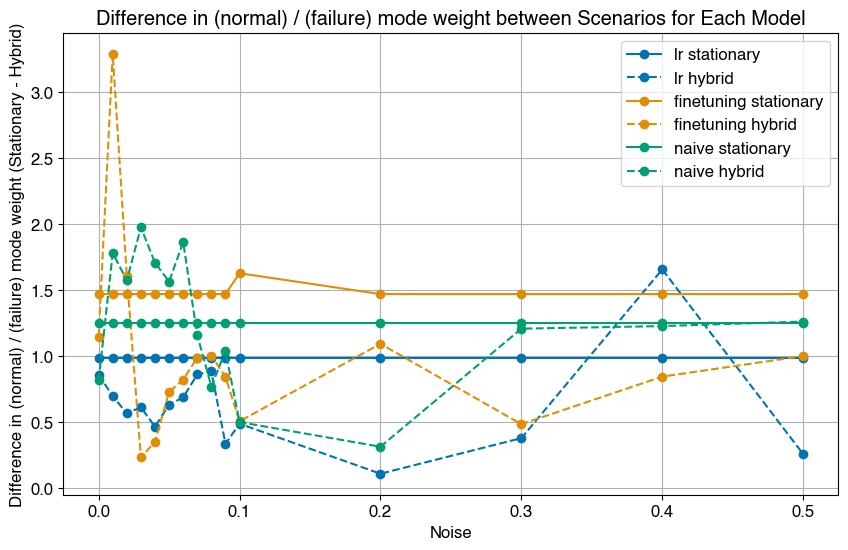

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'evaluations_df' is your DataFrame

# Get the list of unique models and noise levels
models = evaluations_df['model'].unique()
noise_levels = sorted(evaluations_df['noise'].unique())

plt.figure(figsize=(10, 6))

METRIC_NAME = 'WASA'
# STAT_NAME = f'% < 20% {METRIC_NAME}'
# STAT_NAME = f'GMM Mode Centers'
STAT_NAME = f'(normal) / (failure) mode weight'


PALETTE = sns.color_palette('colorblind', n_colors=len(models))

def metric_score(df: pd.DataFrame, plot_column: str = WASA_COLUMN) -> tuple:
    # return np.sum(df[plot_column] < 0.2) / len(df)
    gmm = get_GMM(df)
    means = gmm.means_.flatten()
    mean_sort_idx = means.argsort()
    means = means[mean_sort_idx]
    weights = gmm.weights_[mean_sort_idx]

    return means, weights

def min_over_max(x):
    return np.min(x) / np.max(x)

for idx, model in enumerate(models):
    metric_diff = []
    stationary_means = []
    hybrid_means = []
    for noise in noise_levels:
        # Filter data for the current model and noise level
        df_filtered = evaluations_df[
            (evaluations_df['model'] == model) & (evaluations_df['noise'] == noise)
        ]
        
        # Calculate skew for each scenario
        stationary_df = df_filtered[df_filtered['scenario'] == 'stationary']
        # metric_stationary = stationary_df.skew()
        # metric_stationary = metric_score(stationary_df)
        metric_stationary, weights_stationary = metric_score(stationary_df)
        stationary_scalar = weights_stationary[1] / weights_stationary[0]

        hybrid_df = df_filtered[df_filtered['scenario'] == 'hybrid']
        metric_hybrid = metric_score(hybrid_df)
        metric_hybrid, weights_hybrid = metric_score(hybrid_df)
        hybrid_scalar = weights_hybrid[1] / weights_hybrid[0]
        # hybrid_scalar = min_over_max(weights_hybrid)
        
        # Compute the difference in skew
        metric_difference = metric_stationary - metric_hybrid
        metric_diff.append(metric_difference)

        stationary_means.append(stationary_scalar)
        hybrid_means.append(hybrid_scalar)
        # stationary_means.append(stationary_scalar * np.diff(metric_stationary))
        # hybrid_means.append(hybrid_scalar * np.diff(metric_hybrid))
    
    # Plot the difference
    # plt.plot(noise_levels, metric_diff, label=model, marker='o', color=PALETTE[idx])
    plt.plot(noise_levels, stationary_means, label=f"{model} stationary", marker='o', color=PALETTE[idx])
    plt.plot(noise_levels, hybrid_means, '--', label=f"{model} hybrid", marker='o', color=PALETTE[idx])


plt.xlabel('Noise')
# plt.ylabel(f'Difference in {STAT_NAME}')
plt.ylabel(f'Difference in {STAT_NAME} (Stationary - Hybrid)')
plt.title(f'Difference in {STAT_NAME} between Scenarios for Each Model')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
evaluations_df.to_csv("evaluations_df_plus_noise.csv", index=False)

In [19]:
specgram_export_path = Path('/Users/eric/Engineering/Work/pisces/data_sets/specgrams/pisces')
os.makedirs(specgram_export_path, exist_ok=True)

for idx in range(len(walch_keys)):
    np.save(specgram_export_path.joinpath(f"{walch_keys[idx]}_specgram.npy"), walch_data_bundle.spectrogram[idx])

In [20]:
evaluations_df['noise'].unique()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.2 , 0.3 , 0.4 , 0.5 ])

In [21]:
slice_df = evaluations_df[np.abs(evaluations_df['noise'] - 0.1) < 0.005]

Component Weights: [0.46968191 0.53031809]
Normal Mode Weight (Proportion): 0.53
Failure Mode Weight (Proportion): 0.47
Component Weights: [0.34776208 0.65223792]
Normal Mode Weight (Proportion): 0.35
Failure Mode Weight (Proportion): 0.65


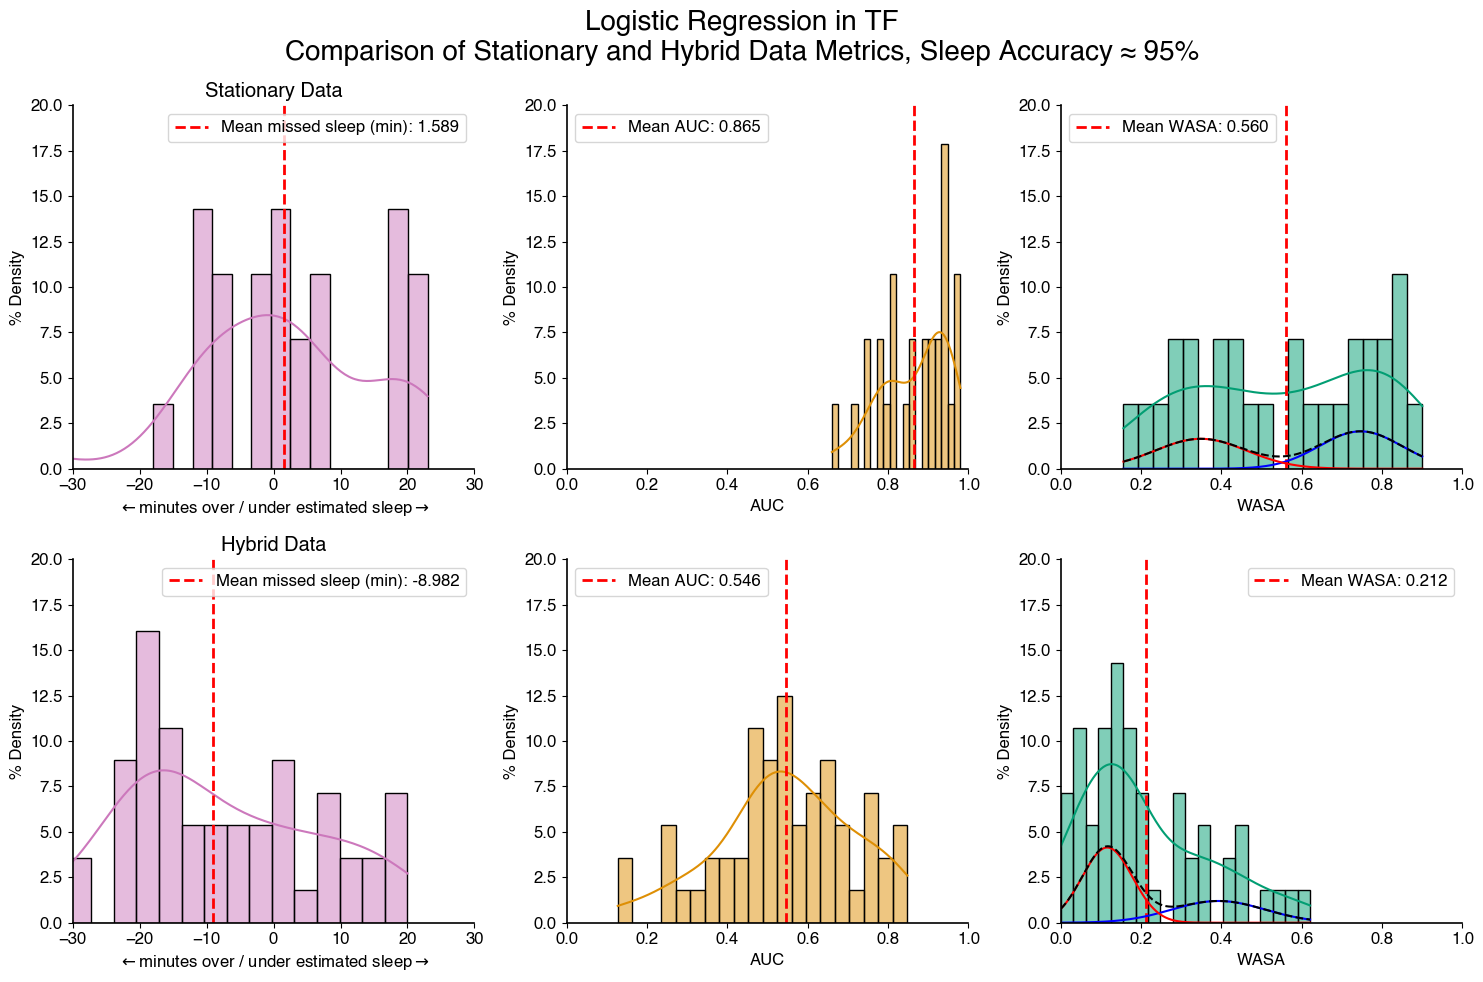

In [22]:
from analyses.NHRC.nhrc_utils.analysis import ACCURACY_COLUMN, AUROC_COLUMN, HYBRID_LOWER, MODEL_COLUMN, SCENARIO_COLUMN, SLEEP_ACCURACY_COLUMN, STATIONARY_LOWER 
from analyses.NHRC.nhrc_utils.model_definitions import LR_LOWER
from analyses.NHRC.nhrc_utils.plotting import tri_plot_metrics

WASA_SLEEP_PERCENT = 95
STATIONARY_SET_NAME = "Stationary Data"
HYBRID_SET_NAME = "Hybrid Data"
SECOND_LINE = f"Sleep Accuracy ≈ {WASA_SLEEP_PERCENT}%"
SECOND_TITLE_LINE = f"Comparison of Stationary and Hybrid Data Metrics, {SECOND_LINE}"
TRIPLOT_DPI = 300
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_df = slice_df[slice_df[MODEL_COLUMN] == LR_LOWER]
plot_df = plot_df[plot_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
lr_stationary = plot_df[plot_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
lr_hybrid = plot_df[plot_df[SCENARIO_COLUMN] == HYBRID_LOWER]

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

add_GMM(lr_stationary, axs[0, -1])
add_GMM(lr_hybrid, axs[1, -1])

for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Logistic Regression in TF\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
# fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{LR_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')

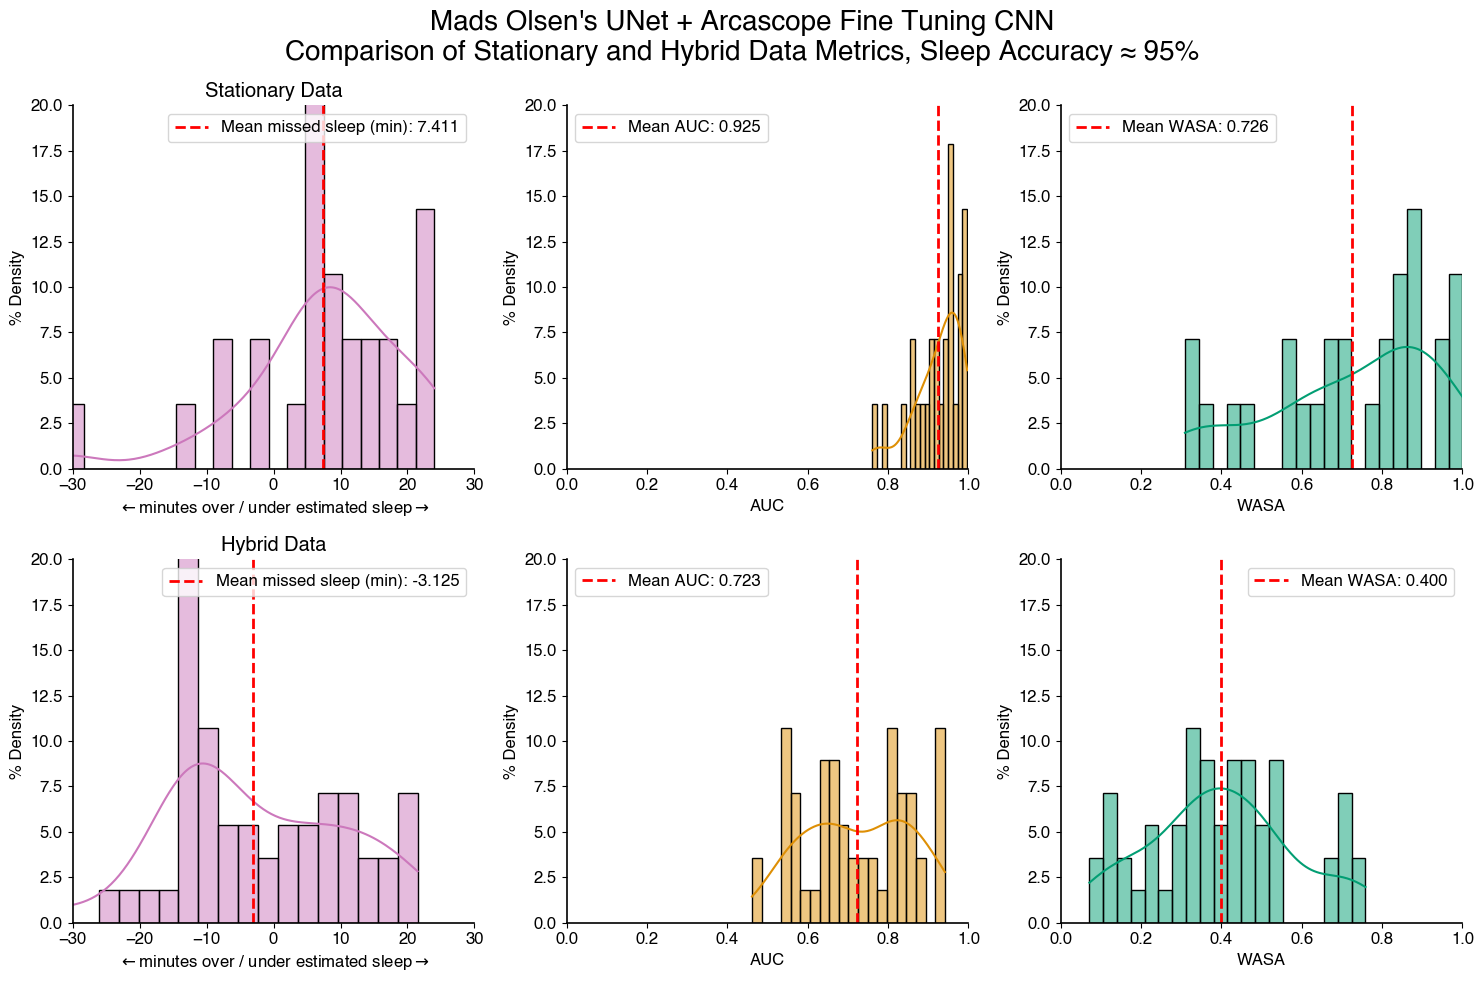

In [23]:
from analyses.NHRC.nhrc_utils.analysis import ACCURACY_COLUMN, AUROC_COLUMN, HYBRID_LOWER, MODEL_COLUMN, SCENARIO_COLUMN, SLEEP_ACCURACY_COLUMN, STATIONARY_LOWER 
from analyses.NHRC.nhrc_utils.model_definitions import EXTRA_LAYERS_NAME, EXTRA_LOWER, LR_LOWER
from analyses.NHRC.nhrc_utils.plotting import tri_plot_metrics

WASA_SLEEP_PERCENT = 95
STATIONARY_SET_NAME = "Stationary Data"
HYBRID_SET_NAME = "Hybrid Data"
SECOND_LINE = f"Sleep Accuracy ≈ {WASA_SLEEP_PERCENT}%"
SECOND_TITLE_LINE = f"Comparison of Stationary and Hybrid Data Metrics, {SECOND_LINE}"
TRIPLOT_DPI = 300
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_df = slice_df[slice_df[MODEL_COLUMN] == EXTRA_LOWER]
plot_df = plot_df[plot_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
lr_stationary = plot_df[plot_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
lr_hybrid = plot_df[plot_df[SCENARIO_COLUMN] == HYBRID_LOWER]

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Mads Olsen's UNet + Arcascope {EXTRA_LAYERS_NAME} CNN\n{SECOND_TITLE_LINE}", fontsize=20)
# fig.suptitle(f"Logistic Regression in TF\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
# fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{LR_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')

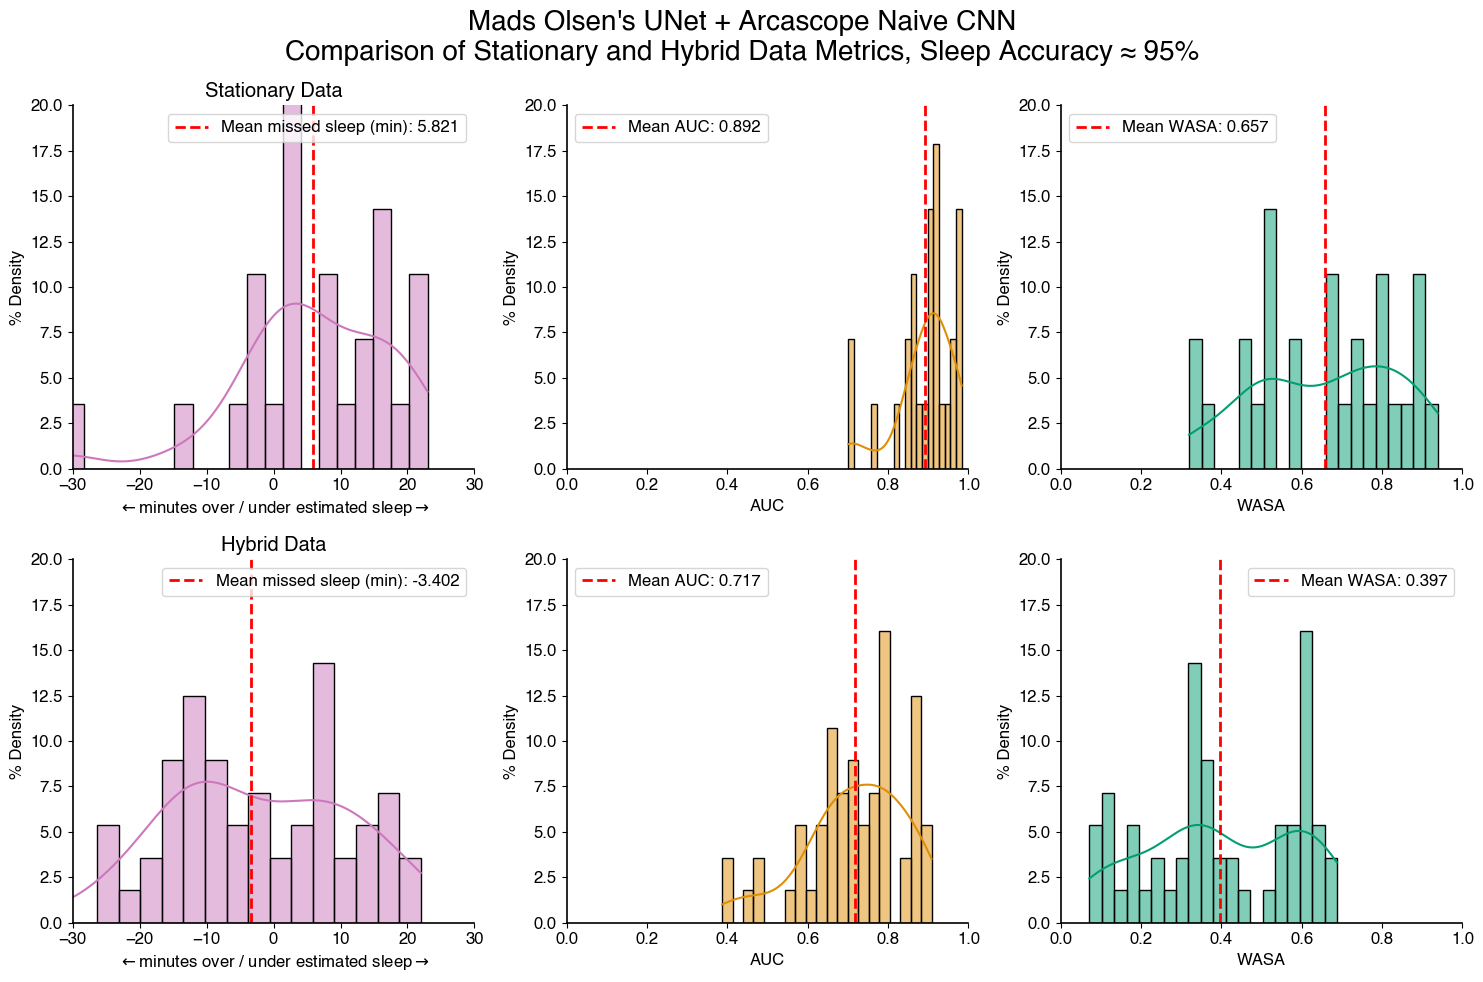

In [24]:
from analyses.NHRC.nhrc_utils.analysis import ACCURACY_COLUMN, AUROC_COLUMN, HYBRID_LOWER, MODEL_COLUMN, SCENARIO_COLUMN, SLEEP_ACCURACY_COLUMN, STATIONARY_LOWER 
from analyses.NHRC.nhrc_utils.model_definitions import EXTRA_LAYERS_NAME, EXTRA_LOWER, NAIVE_LOWER, NAIVE_NAME
from analyses.NHRC.nhrc_utils.plotting import tri_plot_metrics

WASA_SLEEP_PERCENT = 95
STATIONARY_SET_NAME = "Stationary Data"
HYBRID_SET_NAME = "Hybrid Data"
SECOND_LINE = f"Sleep Accuracy ≈ {WASA_SLEEP_PERCENT}%"
SECOND_TITLE_LINE = f"Comparison of Stationary and Hybrid Data Metrics, {SECOND_LINE}"
TRIPLOT_DPI = 300
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

plot_df = slice_df[slice_df[MODEL_COLUMN] == NAIVE_LOWER]
plot_df = plot_df[plot_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
lr_stationary = plot_df[plot_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
lr_hybrid = plot_df[plot_df[SCENARIO_COLUMN] == HYBRID_LOWER]

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Mads Olsen's UNet + Arcascope {NAIVE_NAME} CNN\n{SECOND_TITLE_LINE}", fontsize=20)
# fig.suptitle(f"Logistic Regression in TF\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
# fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{LR_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')